In [1]:
import os
import sys

import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F  
import matplotlib 
import matplotlib.pyplot as plt

In [8]:
EPSILON = 0.05       # Max perturbation (for L∞ PGD)
ALPHA = 0.01         # Step size per iteration
ATTACK_ITERATIONS = 20
TARGET_LABEL = 3     # Example target label for the targeted attack

# System/Model parameters
sys.path.append("/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/models")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/weights/best_model_retrained.pth"
#MODEL_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/weights/justin_model_slicing_norm_LR1_smallHop_12_largerInput.pth"
#IQ_FILE_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_0_1m_run0.iq"  # Example file
#IQ_FILE_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_0_2m_run0.iq"
IQ_FILE_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_0_1m_run2.iq"



In [4]:
from attempt2 import resnet50_1d  # Directly import from attempt2.py
num_classes = 8  # Change this if your model was trained with a different number of classes

# Initialize the model architecture
model = resnet50_1d(num_classes=num_classes).to(DEVICE)

# Load trained weights
MODEL_PATH = "/home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/weights/justin_model_slicing_norm_LR1_smallHop_12.pth"
print(f"Loading trained model weights from: {MODEL_PATH}")
state_dict = torch.load(MODEL_PATH, map_location=DEVICE)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# Set the model to evaluation mode
model.eval()

Loading trained model weights from: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/weights/justin_model_slicing_norm_LR1_smallHop_12.pth


/tmp/ipykernel_3961446/1761318717.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(MODEL_PATH, map_location=DEVICE)


ResNet1D(
  (conv1): Conv1d(2, 64, kernel_size=(7,), stride=(2,), padding=(3,), bias=False)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck1D(
      (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
      (bn3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (downsample): Sequential(
        (0): Conv1d(64, 256, kernel_size=(1,), stride=(1,), bias=False)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True

In [5]:
def load_iq_data(file_path, max_samples=4096*2, start_idx=0):
    """
    Loads a limited portion of `.iq` data.
    
    Args:
        file_path (str): Path to the `.iq` file.
        max_samples (int): The number of samples to load.
        start_idx (int): The starting index to read from.

    Returns:
        data_tensor (torch.Tensor): shape [1, 2, max_samples]
        label_tensor (torch.Tensor): Dummy label for testing.
    """
    total_samples = max_samples * 2  # Since I/Q samples are interleaved

    #  Open the file in binary mode and seek to `start_idx`
    with open(file_path, "rb") as f:
        f.seek(start_idx * 4 * 2)  # 4 bytes per float32, 2 channels (I/Q)
        raw_data = np.fromfile(f, dtype="float32", count=total_samples)

    #  Ensure we have enough data
    if raw_data.shape[0] < total_samples:
        raise ValueError(f"Not enough data in {file_path}. Requested {total_samples}, got {raw_data.shape[0]}.")

    #  Extract I/Q channels
    I = raw_data[0::2]  # Even indices
    Q = raw_data[1::2]  # Odd indices

    #  Stack into [2, max_samples] format
    iq_data = np.stack([I, Q], axis=0)

    #  Add batch dimension → [1, 2, max_samples]
    iq_data = np.expand_dims(iq_data, axis=0)

    #  Convert to PyTorch tensor
    data_tensor = torch.from_numpy(iq_data).float()

    #  Dummy label for now (adjust if needed)
    label_tensor = torch.tensor([0], dtype=torch.long)

    return data_tensor, label_tensor

In [6]:
def targeted_pgd_attack(model, x, y, target_label, eps, alpha, num_iter):

    model.eval()
    
    if isinstance(target_label, int):
        target_label = torch.full_like(y, target_label)
    
    x_adv = x.clone().detach().to(DEVICE)
    x_adv.requires_grad = True

    for _ in range(num_iter):
        outputs = model(x_adv)
        
        loss = -nn.CrossEntropyLoss()(outputs, target_label)

        model.zero_grad()
        loss.backward()

        grad = x_adv.grad.data
        x_adv = x_adv.detach() + alpha * grad.sign()

        x_adv = torch.min(torch.max(x_adv, x - eps), x + eps)

        x_adv.requires_grad = True

    return x_adv.detach()

Loading data from: /home/jfeng/Desktop/jfeng/rf_spoofing/spoofing/1m_2m_replacedPluto4/1m_2m/Pluto_0_1m_run2.iq
Original data shape:  torch.Size([1, 2, 8192])
Original prediction: [7], Confidence: 0.5031


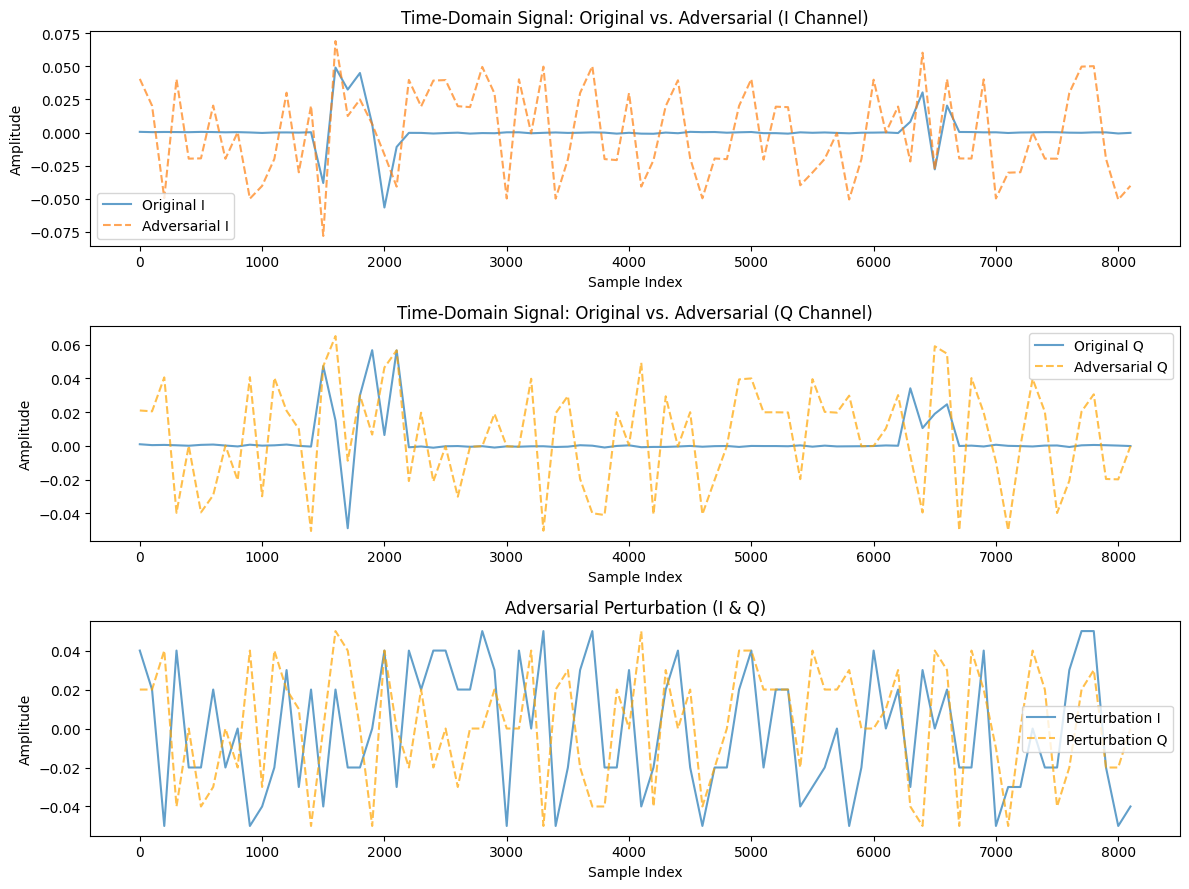

First 10 values of the interleaved perturbation sequence: [ 0.04  0.02  0.04  0.04  0.05  0.05 -0.04  0.04 -0.04 -0.05]
Adversarial prediction: [3], Confidence: 0.9976
0.04


In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def main():
    print(f"Loading data from: {IQ_FILE_PATH}")
    data, labels = load_iq_data(IQ_FILE_PATH)
    data, labels = data.to(DEVICE), labels.to(DEVICE)

    print("Original data shape: ", data.shape)  # Expected shape: [1, 2, N]

    model.eval()
    
    with torch.no_grad():
        logits = model(data)  # Raw model output
        probs = F.softmax(logits, dim=1)  # Convert to probabilities
        original_pred = torch.argmax(probs, dim=1)  # Get predicted class
        confidence = probs.max(dim=1).values  # Get confidence score of predicted class

    print(f"Original prediction: {original_pred.cpu().numpy()}, Confidence: {confidence.cpu().item():.4f}")

    #make adversarial example with PGD
    x_adv = targeted_pgd_attack(
        model=model,
        x=data,
        y=labels,
        target_label=TARGET_LABEL,  
        eps=EPSILON,
        alpha=ALPHA,
        num_iter=ATTACK_ITERATIONS
    )
    
    perturbations = x_adv - data  # Get the difference between adversarial and original data
    perturbations_np = perturbations.cpu().detach().numpy()
    
    data_np = data.cpu().detach().numpy()
    x_adv_np = x_adv.cpu().detach().numpy()

    I_orig = data_np[0, 0, :]  # Original In-phase component
    Q_orig = data_np[0, 1, :]  # Original Quadrature component

    I_adv = x_adv_np[0, 0, :]  # Adversarial In-phase component
    Q_adv = x_adv_np[0, 1, :]  # Adversarial Quadrature component

    I_diff = perturbations_np[0, 0, :]  # Perturbation (I channel)
    Q_diff = perturbations_np[0, 1, :]  # Perturbation (Q channel)

    interleaved_perturbations = np.empty((I_diff.size + Q_diff.size,), dtype=np.float32)
    interleaved_perturbations[0::2] = I_diff  # Place I values at even indices
    interleaved_perturbations[1::2] = Q_diff  # Place Q values at odd indices
    
    # Save the interleaved perturbation IQ sequence as a binary .iq file
    FILENAME = "Apr16/pluto10_to_target1_noise.iq"
    interleaved_perturbations.astype("float32").tofile(FILENAME)


    time = np.arange(I_orig.shape[0])

    downsample_factor = 100  # Adjust as needed
    time_downsampled = time[::downsample_factor]

    I_orig_downsampled = I_orig[::downsample_factor]
    Q_orig_downsampled = Q_orig[::downsample_factor]

    I_adv_downsampled = I_adv[::downsample_factor]
    Q_adv_downsampled = Q_adv[::downsample_factor]

    I_diff_downsampled = I_diff[::downsample_factor]
    Q_diff_downsampled = Q_diff[::downsample_factor]
    
    plt.figure(figsize=(12, 9))

    # Plot original and adversarial I-channel
    plt.subplot(3, 1, 1)
    plt.plot(time_downsampled, I_orig_downsampled, label="Original I", alpha=0.7)
    plt.plot(time_downsampled, I_adv_downsampled, label="Adversarial I", linestyle="dashed", alpha=0.7)
    plt.title("Time-Domain Signal: Original vs. Adversarial (I Channel)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()

    # Plot original and adversarial Q-channel
    plt.subplot(3, 1, 2)
    plt.plot(time_downsampled, Q_orig_downsampled, label="Original Q", alpha=0.7)
    plt.plot(time_downsampled, Q_adv_downsampled, label="Adversarial Q", linestyle="dashed", alpha=0.7, color='orange')
    plt.title("Time-Domain Signal: Original vs. Adversarial (Q Channel)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()

    # Plot the difference (perturbation) for both channels
    plt.subplot(3, 1, 3)
    plt.plot(time_downsampled, I_diff_downsampled, label="Perturbation I", alpha=0.7)
    plt.plot(time_downsampled, Q_diff_downsampled, label="Perturbation Q", linestyle="dashed", alpha=0.7, color='orange')
    plt.title("Adversarial Perturbation (I & Q)")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Interleave I and Q to form an IQIQIQ... sequence
    interleaved = np.empty((I_diff.size + Q_diff.size,), dtype=I_diff.dtype)
    interleaved[0::2] = I_diff
    interleaved[1::2] = Q_diff


    

    print("First 10 values of the interleaved perturbation sequence:", interleaved[:10])
    
    # Optionally, save the sequence to a file for your experiment
    np.savetxt("perturbations_sequence.txt", interleaved, fmt='%f')

    # Evaluate the adversarial example
    with torch.no_grad():
        adv_logits = model(x_adv)  # Raw output for adversarial example
        adv_probs = F.softmax(adv_logits, dim=1)  # Convert to probabilities
        adv_pred = torch.argmax(adv_probs, dim=1)  # Get predicted class
        adv_confidence = adv_probs.max(dim=1).values  # Get confidence score

    print(f"Adversarial prediction: {adv_pred.cpu().numpy()}, Confidence: {adv_confidence.cpu().item():.4f}")

    print(I_diff[0])


if __name__ == "__main__":
    main()
